In [1]:
import pandas as pd
import duckdb

In [7]:
db = "../../data/raw_data.db"

conn = duckdb.connect(db)
df = conn.execute("SELECT * FROM raw_summoner_game_logs where game_start_timestamp >= DATE '2025-04-14';").fetchdf()
print(f"[INFO] Load {len(df)} records: {len(df.summoner_id.unique())} summoners.")
df.fillna({"rank": "None"}, inplace=True)
df.groupby(["tier", "rank"]).summoner_id.nunique()

[INFO] Load 57457 records: 874 summoners.


tier         rank
CHALLENGER   None     30
DIAMOND      I        44
             II       51
             III      47
             IV      127
EMERALD      I       100
             II      109
             III     165
             IV      114
GRANDMASTER  None     30
MASTER       None     57
Name: summoner_id, dtype: int64

In [8]:
# 1.1 D-d Retention  ─ 수정본
from datetime import datetime, timedelta

df["timestamp"] = df["game_start_timestamp"].dt.date          # datetime → date

today  = datetime(2025, 5, 14).date()
d0     = today - timedelta(days=30)                            # Cohort 기준일
cohort = set(df[df.timestamp == d0].summoner_id.unique())      # D0 유저 집합
print(f"[INFO] Cohort Size: {len(cohort)}")

for d in [1, 3, 7, 30]:
    day = d0 + timedelta(days=d)
    comeback = set(df[df.timestamp == day].summoner_id.unique())
    
    retention = len(cohort & comeback) / len(cohort)           # 분모 고정
    print(f"[INFO] D-{d} Retention = {retention:.4f}")

[INFO] Cohort Size: 307
[INFO] D-1 Retention = 0.6808
[INFO] D-3 Retention = 0.6645
[INFO] D-7 Retention = 0.5961
[INFO] D-30 Retention = 0.2020


In [23]:
# NOTE: game_duration 데이터가 오염되었음을 확인, df["game_end_timestamp"] - df["game_start_timestamp"]을 대신 사용해야.
minutes = df["game_duration"].dt.total_seconds() / 60
print(minutes.describe())

df["new_game_duration"] = df["game_end_timestamp"] - df["game_start_timestamp"]
minutes = df["new_game_duration"].dt.total_seconds() / 60
print(minutes.describe())

count    57457.000000
mean        16.082926
std         13.130661
min          0.001667
25%          0.028717
50%         19.266667
75%         27.016667
max         59.950000
Name: game_duration, dtype: float64
count    57457.000000
mean        24.751682
std          7.254019
min          1.670067
25%         19.710417
50%         24.974700
75%         29.356750
max         59.957150
Name: new_game_duration, dtype: float64


,game_mode,timestamp,session_length,session_minutes
0,ARAM,2025-04-14,0 days 00:59:40.830000,59.680500
1,ARAM,2025-04-15,0 days 00:58:39.169000,58.652817
2,ARAM,2025-04-16,0 days 00:36:22.599500,36.376658
3,ARAM,2025-04-17,0 days 00:48:20.797000,48.346617
4,ARAM,2025-04-18,0 days 00:50:30.688000,50.511467
...,...,...,...,...
107,SWIFTPLAY,2025-05-03,0 days 03:08:19.687000,188.328117
108,SWIFTPLAY,2025-05-07,0 days 00:45:16.041000,45.267350
109,SWIFTPLAY,2025-05-12,0 days 00:32:53.910000,32.898500
110,SWIFTPLAY,2025-05-13,0 days 00:56:24.974000,56.416233


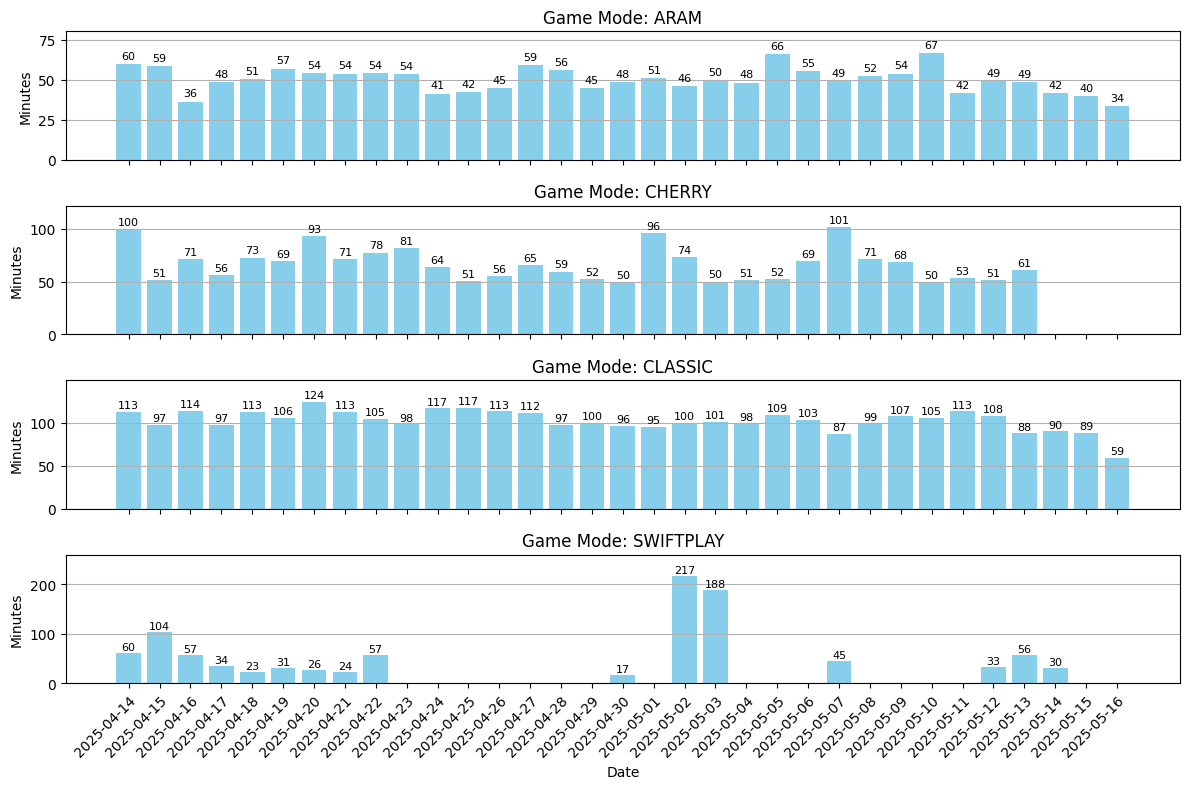

In [24]:
# 1.2 Average Session Length -> 지속시간, 몰입도, 콘텐츠 길이
avg_session_length = df.groupby(["game_mode", "timestamp", "summoner_id"]).new_game_duration.sum().reset_index(name="session_length")
avg_session_length = avg_session_length.groupby(["game_mode", "timestamp"]).session_length.median().reset_index() # 편차가 큰 편이라 조금 더 robust한 median 사용
avg_session_length["session_minutes"] = avg_session_length["session_length"].dt.total_seconds() / 60
display(avg_session_length)

import matplotlib.pyplot as plt
modes = avg_session_length["game_mode"].unique()
fig, axes = plt.subplots(nrows=len(modes), ncols=1, figsize=(12, 8), sharex=True)

for ax, mode in zip(axes, modes):
    subset = avg_session_length[avg_session_length["game_mode"] == mode]
    bars = ax.bar(subset["timestamp"], subset["session_minutes"], color="skyblue")
    ax.set_title(f"Game Mode: {mode}")
    ax.set_ylabel("Minutes")
    ax.grid(axis='y')

    max_height = max([bar.get_height() for bar in bars])
    ax.set_ylim(0, max_height * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{height:.0f}', 
                ha='center', va='bottom', fontsize=8)

unique_dates = sorted(avg_session_length.timestamp.unique())
plt.xlabel("Date")
plt.xticks(ticks=unique_dates, rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show()


,game_mode,timestamp,summoner_count,session_count,result
0,ARAM,2025-04-14,63,314,4.984127
1,ARAM,2025-04-15,59,215,3.644068
2,ARAM,2025-04-16,50,168,3.360000
3,ARAM,2025-04-17,77,296,3.844156
4,ARAM,2025-04-18,89,349,3.921348
...,...,...,...,...,...
107,SWIFTPLAY,2025-05-03,1,12,12.000000
108,SWIFTPLAY,2025-05-07,1,2,2.000000
109,SWIFTPLAY,2025-05-12,2,4,2.000000
110,SWIFTPLAY,2025-05-13,1,4,4.000000


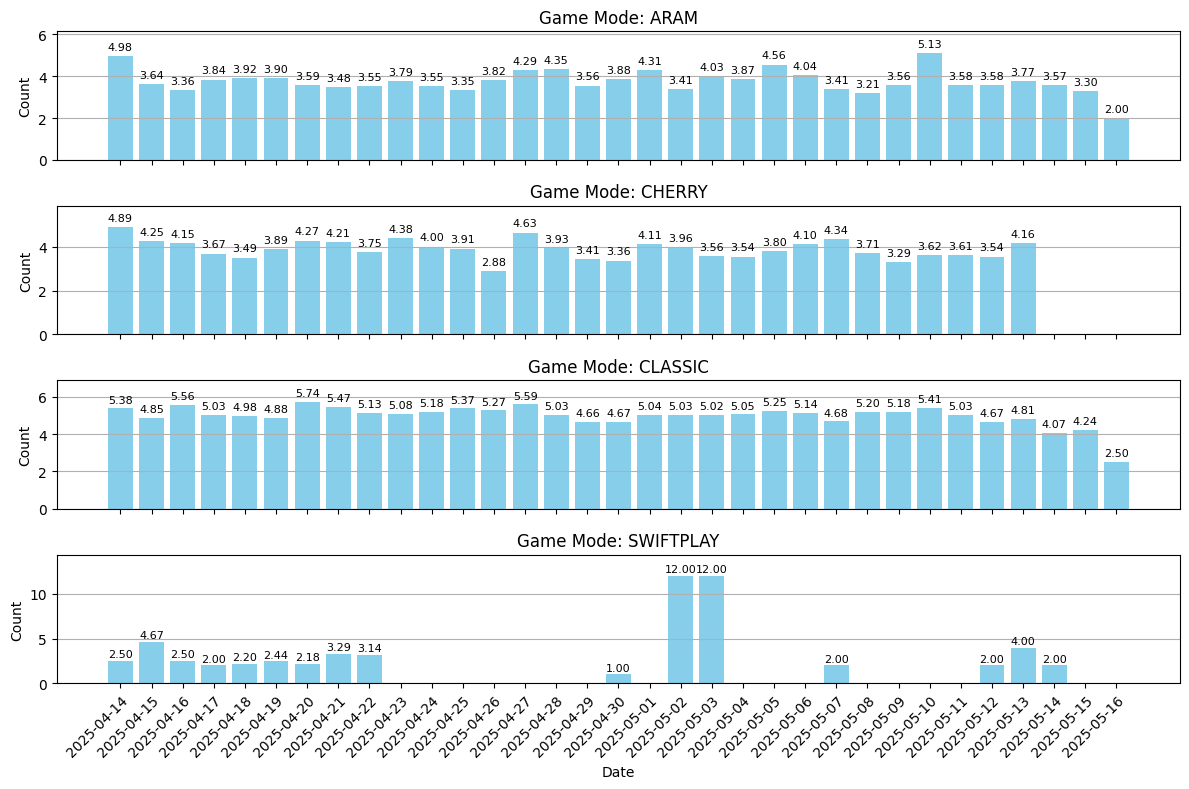

In [25]:
# 1.3 Sessions per User per Day -> 빈도, 활동 습관, 반복성
sessions_per_summoner_per_day = df.groupby(["game_mode", "timestamp"]).summoner_id.nunique().reset_index(name="summoner_count")
sessions_per_summoner_per_day["session_count"] = df.groupby(["game_mode", "timestamp"]).size().reset_index(drop=True)
sessions_per_summoner_per_day["result"] = sessions_per_summoner_per_day["session_count"] / sessions_per_summoner_per_day["summoner_count"]
display(sessions_per_summoner_per_day)

modes = sessions_per_summoner_per_day["game_mode"].unique()
fig, axes = plt.subplots(nrows=len(modes), ncols=1, figsize=(12, 8), sharex=True)

for ax, mode in zip(axes, modes):
    subset = sessions_per_summoner_per_day[sessions_per_summoner_per_day["game_mode"] == mode]
    bars = ax.bar(subset["timestamp"], subset["result"], color="skyblue")
    ax.set_title(f"Game Mode: {mode}")
    ax.set_ylabel("Count")
    ax.grid(axis='y')

    max_height = max([bar.get_height() for bar in bars])
    ax.set_ylim(0, max_height * 1.2)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + .2, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=8)

unique_dates = sorted(sessions_per_summoner_per_day.timestamp.unique())
plt.xlabel("Date")
plt.xticks(ticks=unique_dates, rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
plt.show()

In [6]:
# 1.4 D-d Churn Rate
today = datetime(2025, 5, 14)
cohort_date = today - timedelta(days=30)
cohort_ids = set(df[df.timestamp == cohort_date.date()].summoner_id.unique())
print(f"[INFO] Cohort Size: {len(cohort_ids)}")

for d in [3, 7, 14, 30]:
    cohort_cutoff = cohort_date + timedelta(days=d)
    returned_ids = set(df[
        (df.timestamp > cohort_date.date()) & 
        (df.timestamp <= cohort_cutoff.date())
    ].summoner_id.unique()) & cohort_ids
    
    churned = cohort_ids - returned_ids
    churn_rate = len(churned) / len(cohort_ids)
    print(f"[INFO] D-{d} Churn Rate is {churn_rate:.4f}")

[INFO] Cohort Size: 220
[INFO] D-3 Churn Rate is 0.1091
[INFO] D-7 Churn Rate is 0.0364
[INFO] D-14 Churn Rate is 0.0182
[INFO] D-30 Churn Rate is 0.0045


In [7]:
# 2.1 Access Rate to New Content
target_modes = ["CHERRY", "SWIFTPLAY"]
today = datetime(2025, 5, 14)
ds = [0, 14, 30]
for target_mode in target_modes:
    for d in ds:
        cohort_date = today - timedelta(days=d)
        total_users = set(df[df.timestamp == cohort_date.date()].summoner_id.unique())
        new_content_users = set(df[
            (df.timestamp == cohort_date.date()) &
            (df.game_mode == target_mode)
        ].summoner_id.unique())
        access_rate = len(new_content_users) / len(total_users) if total_users else 0
        print(f"[INFO] {cohort_date.date()}'s Access Rate for New Content '{target_mode}': {access_rate:.4f}")

target_champ = "Mel"
for d in ds:
    cohort_date = today - timedelta(days=d)
    total_users = set(df[df.timestamp == cohort_date.date()].summoner_id.unique())
    new_content_users = set(df[
        (df.timestamp == cohort_date.date()) &
        (df.champion_name == target_champ)
    ].summoner_id.unique())
    access_rate = len(new_content_users) / len(total_users) if total_users else 0
    print(f"[INFO] {cohort_date.date()}'s Access Rate for New Content '{target_champ}': {access_rate:.4f}")


[INFO] 2025-05-14's Access Rate for New Content 'CHERRY': 0.0000
[INFO] 2025-04-30's Access Rate for New Content 'CHERRY': 0.1459
[INFO] 2025-04-14's Access Rate for New Content 'CHERRY': 0.1591
[INFO] 2025-05-14's Access Rate for New Content 'SWIFTPLAY': 0.0000
[INFO] 2025-04-30's Access Rate for New Content 'SWIFTPLAY': 0.0043
[INFO] 2025-04-14's Access Rate for New Content 'SWIFTPLAY': 0.0182
[INFO] 2025-05-14's Access Rate for New Content 'Mel': 0.0625
[INFO] 2025-04-30's Access Rate for New Content 'Mel': 0.0300
[INFO] 2025-04-14's Access Rate for New Content 'Mel': 0.0318


In [8]:
# 2.2 Average/Median Play Count per User
target_modes = ["CHERRY", "SWIFTPLAY"]
for target_mode in target_modes:
    play_counts = df[df.game_mode == target_mode].groupby("summoner_id").size()

    all_users = pd.Series(0, index=df["summoner_id"].unique())
    all_users[play_counts.index] = play_counts

    average_play_count = all_users.mean()
    median_play_count = all_users.median()
    
    print(f"[INFO] Average Play Count per User (30d) for '{target_mode}': {average_play_count:.2f}")
    print(f"[INFO] Median Play Count per User (30d) for '{target_mode}': {median_play_count:.0f}")

target_champ = "Mel"
play_counts = df[df.champion_name == target_champ].groupby("summoner_id").size()

all_users = pd.Series(0, index=df["summoner_id"].unique())
all_users[play_counts.index] = play_counts

average_play_count = all_users.mean()
median_play_count = all_users.median()

print(f"[INFO] Average Play Count per User (30d) for '{target_champ}': {average_play_count:.2f}")
print(f"[INFO] Median Play Count per User (30d) for '{target_champ}': {median_play_count:.0f}")

[INFO] Average Play Count per User (30d) for 'CHERRY': 7.97
[INFO] Median Play Count per User (30d) for 'CHERRY': 0
[INFO] Average Play Count per User (30d) for 'SWIFTPLAY': 0.21
[INFO] Median Play Count per User (30d) for 'SWIFTPLAY': 0
[INFO] Average Play Count per User (30d) for 'Mel': 0.53
[INFO] Median Play Count per User (30d) for 'Mel': 0


In [9]:
# 픽률
x = df[(df.game_mode == 'CLASSIC') & (df.tier == "DIAMOND")]
y = x.champion_name.value_counts() / len(x)
y

champion_name
Lucian    0.031437
Zed       0.030303
Ezreal    0.027108
LeeSin    0.024634
Kaisa     0.024325
            ...   
Zyra      0.000309
Rengar    0.000309
Sona      0.000309
Amumu     0.000309
Ivern     0.000103
Name: count, Length: 168, dtype: float64

In [19]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import duckdb

# ---------------------------
# 0) weight 테이블 로드
# ---------------------------
weight_df = pd.read_csv("../../data/metadata.csv")
weight_df["key"] = list(zip(weight_df["tier"], weight_df["division"].fillna("")))
weight_map = dict(zip(weight_df["key"], weight_df["weight"]))

# ---------------------------
# 1) 데이터 로드 + weight 컬럼 부착
# ---------------------------
db = "../../data/raw_data.db"
conn = duckdb.connect(db)
df = conn.execute("SELECT * FROM raw_summoner_game_logs where game_start_timestamp >= DATE '2025-04-14';").fetchdf()
df['timestamp'] = df['game_start_timestamp'].apply(lambda x: x.date())
print(f"[INFO] Load {len(df)} records: {df.summoner_id.nunique()} summoners.")

# tier/division → weight
df["division"] = df["rank"].fillna("")
df["w"] = list(
    df.apply(lambda r: weight_map.get((r["tier"], r["division"]), 1.0), axis=1)
)

# =========================================================================
# 1.1 D-d Retention (가중 비율)
# -------------------------------------------------------------------------
today = datetime(2025, 5, 14)
target = today - timedelta(days=30)

target_mask = df["timestamp"] == target.date()
target_users = df[target_mask].groupby("summoner_id")["w"].mean()        # weight per user
target_total_w = len(target_users)

for d in [1, 3, 7, 30]:
    d_date = (target + timedelta(days=d)).date()
    comeback_mask = df["timestamp"] == d_date
    comeback_users = df[comeback_mask].groupby("summoner_id")["w"].mean()

    inter = target_users.index.intersection(comeback_users.index)
    retained_w = len(target_users.loc[inter])           # 공집합이면 0

    d_retention = retained_w / target_total_w if target_total_w else 0
    print(f"[INFO] D-{d} Weighted Retention = {d_retention:.4f}")

# =========================================================================
# 1.2 Average Session Length (가중 평균; median은 선택)
# -------------------------------------------------------------------------
g = (
    df.groupby(["game_mode", "timestamp", "summoner_id"])
      .agg(session_length=("new_game_duration", "sum"), w=("w", "mean"))
      .reset_index()
)

def w_avg(x):
    return np.average(x["session_length"].dt.total_seconds()/60, weights=x["w"])

avg_len = (
    g.groupby(["game_mode", "timestamp"])
     .apply(w_avg, include_groups=False).reset_index(name="avg_minutes")
)

def weighted_median(tbl: pd.DataFrame) -> float:
    """tbl: 한 날짜-한 게임모드의 세션 길이·weight 집합
       반환값: 가중 중앙값(분 단위)"""
    # 숫자 단위로 변환
    tbl = tbl.assign(m = tbl["session_length"].dt.total_seconds() / 60)
    tbl = tbl.sort_values("m")                         # ① 정렬
    cum_w = tbl["w"].cumsum()                          # ② 누적 가중치
    cutoff = tbl["w"].sum() / 2                        # 50 %
    return tbl.loc[cum_w >= cutoff, "m"].iloc[0]       # ③ 첫 번째 지점

# groupby 후 apply
w_median_len = (
    g.groupby(["game_mode", "timestamp"])
     .apply(weighted_median, include_groups=False)
     .reset_index(name="w_median_minutes")
)

display(w_median_len)

# =========================================================================
# 1.3 Sessions per User per Day (가중)
# -------------------------------------------------------------------------
per_day = df.groupby(["game_mode", "timestamp", "summoner_id"]).agg(
            sess=("summoner_id", "size"),
            w=("w", "mean")
         ).reset_index()

def w_avg_sess(x):
    return np.average(x["sess"], weights=x["w"])   # 핵심

tmp = (
    per_day.groupby(["game_mode", "timestamp"])
           .apply(w_avg_sess, include_groups=False)   # pandas 2.1+
           .reset_index(name="result")
)

display(tmp)

# =========================================================================
# 1.4 Churn Rate (가중)
# -------------------------------------------------------------------------
cohort_date = today - timedelta(days=30)
cohort_users = df[df["timestamp"] == cohort_date.date()].groupby("summoner_id")["w"].mean()
cohort_w = cohort_users.sum()

for d in [3, 7, 14, 30]:
    cutoff = (cohort_date + timedelta(days=d)).date()
    returned = df[
        (df["timestamp"] > cohort_date.date()) & (df["timestamp"] <= cutoff)
    ].groupby("summoner_id")["w"].mean()
    inter = cohort_users.index.intersection(returned.index)
    retained_w = cohort_users.loc[inter].sum()
    churn_rate = 1 - retained_w / cohort_w if cohort_w else 0
    print(f"[INFO] D-{d} Weighted Churn = {churn_rate:.4f}")

# =========================================================================
# 2.1 Access Rate (가중)
# -------------------------------------------------------------------------
for mode in ["CHERRY", "SWIFTPLAY"]:
    for d in [0, 14, 30]:
        day = (today - timedelta(days=d)).date()
        daily = df[df["timestamp"] == day]
        tot_w = daily.groupby("summoner_id")["w"].mean().sum()
        new_w = daily[daily["game_mode"] == mode].groupby("summoner_id")["w"].mean().sum()
        rate  = new_w / tot_w if tot_w else 0
        print(f"[INFO] {day} Access '{mode}': {rate:.4f}")

target_champ = "Mel"
for d in [0, 14, 30]:
    day = (today - timedelta(days=d)).date()
    daily = df[df["timestamp"] == day]
    tot_w = daily.groupby("summoner_id")["w"].mean().sum()
    new_w = daily[daily["champion_name"] == target_champ].groupby("summoner_id")["w"].mean().sum()
    rate  = new_w / tot_w if tot_w else 0
    print(f"[INFO] {day} Access '{target_champ}': {rate:.4f}")

# =========================================================================
# 2.2 Average Play Count (가중)
# -------------------------------------------------------------------------
for mode in ["CHERRY", "SWIFTPLAY", "CLASSIC", "ARAM"]:
    pc = df[(df.timestamp == datetime(2025,4,15).date()) & (df["game_mode"] == mode)].groupby("summoner_id").agg(
            plays=("game_mode", "size"),
            w=("w", "mean")
         )
    # 0회 유저 포함하기
    all_w = df[df.timestamp == datetime(2025,4,15).date()].groupby("summoner_id")["w"].mean()
    pc = pc.reindex(all_w.index, fill_value=0)
    pc["w"] = all_w

    avg_play = np.average(pc["plays"], weights=pc["w"])
    # 가중 중앙값은 별도 함수 필요 → 간단 approximate
    pc_sorted = pc.sort_values("plays")
    cum_w = pc_sorted["w"].cumsum()
    median_play = pc_sorted.loc[cum_w >= pc_sorted["w"].sum()/2, "plays"].iloc[0]

    print(f"[INFO] {mode}  Weighted Avg Play = {avg_play:.2f} | Weighted Median = {median_play}")

target_champ = "Mel"
pc = df[(df.timestamp == datetime(2025,4,15).date()) & (df["champion_name"] == target_champ)].groupby("summoner_id").agg(
        plays=("champion_name", "size"),
        w=("w", "mean")
     )
# 0회 유저 포함하기
all_w = df[df.timestamp == datetime(2025,4,15).date()].groupby("summoner_id")["w"].mean()
pc = pc.reindex(all_w.index, fill_value=0)
pc["w"] = all_w

avg_play = np.average(pc["plays"], weights=pc["w"])
# 가중 중앙값은 별도 함수 필요 → 간단 approximate
pc_sorted = pc.sort_values("plays")
cum_w = pc_sorted["w"].cumsum()
median_play = pc_sorted.loc[cum_w >= pc_sorted["w"].sum()/2, "plays"].iloc[0]

print(f"[INFO] {target_champ}  Weighted Avg Play = {avg_play:.2f} | Weighted Median = {median_play}")

[INFO] Load 40397 records: 559 summoners.
[INFO] D-1 Weighted Retention = 0.7136
[INFO] D-3 Weighted Retention = 0.6818
[INFO] D-7 Weighted Retention = 0.6091
[INFO] D-30 Weighted Retention = 0.0455


,game_mode,timestamp,w_median_minutes
0,ARAM,2025-04-14,66.766667
1,ARAM,2025-04-15,61.400000
2,ARAM,2025-04-16,43.933333
3,ARAM,2025-04-17,48.333333
4,ARAM,2025-04-18,63.650000
...,...,...,...
99,SWIFTPLAY,2025-04-21,22.983333
100,SWIFTPLAY,2025-04-22,27.683333
101,SWIFTPLAY,2025-04-30,17.333333
102,SWIFTPLAY,2025-05-12,9.766667


,game_mode,timestamp,result
0,ARAM,2025-04-14,5.143136
1,ARAM,2025-04-15,3.534605
2,ARAM,2025-04-16,3.096238
3,ARAM,2025-04-17,3.815062
4,ARAM,2025-04-18,4.282240
...,...,...,...
99,SWIFTPLAY,2025-04-21,2.200000
100,SWIFTPLAY,2025-04-22,3.000000
101,SWIFTPLAY,2025-04-30,1.000000
102,SWIFTPLAY,2025-05-12,1.000000


[INFO] D-3 Weighted Churn = 0.1199
[INFO] D-7 Weighted Churn = 0.0450
[INFO] D-14 Weighted Churn = 0.0225
[INFO] D-30 Weighted Churn = 0.0056
[INFO] 2025-05-14 Access 'CHERRY': 0.0000
[INFO] 2025-04-30 Access 'CHERRY': 0.1243
[INFO] 2025-04-14 Access 'CHERRY': 0.1380
[INFO] 2025-05-14 Access 'SWIFTPLAY': 0.0000
[INFO] 2025-04-30 Access 'SWIFTPLAY': 0.0052
[INFO] 2025-04-14 Access 'SWIFTPLAY': 0.0226
[INFO] 2025-05-14 Access 'Mel': 0.0624
[INFO] 2025-04-30 Access 'Mel': 0.0369
[INFO] 2025-04-14 Access 'Mel': 0.0395
[INFO] CHERRY  Weighted Avg Play = 0.89 | Weighted Median = 0
[INFO] SWIFTPLAY  Weighted Avg Play = 0.06 | Weighted Median = 0
[INFO] CLASSIC  Weighted Avg Play = 3.95 | Weighted Median = 3
[INFO] ARAM  Weighted Avg Play = 0.70 | Weighted Median = 0
[INFO] Mel  Weighted Avg Play = 0.03 | Weighted Median = 0


In [22]:
df.timestamp.max()

datetime.date(2025, 5, 14)